In [2]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from keras.models import load_model

In [23]:
# make inline plots larger
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 160

In [876]:
# Initialize TensorFlow.
tflib.init_tf()

# Load pre-trained StyleGAN network.
url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
# url = 'https://drive.google.com/uc?id=1MQywl0FNt6lHu8E_EUqnRbviagS7fbiJ' # stylegan-cats-256x256.pkl
with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
    _G, _D, Gs = pickle.load(f)
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

# Print network details.
Gs.print_layers()


Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

In [1338]:
# Generate provided number of latent vectors
def gen_latents(count):
    latents = rnd.randn(count, Gs.input_shape[1])
    return latents

# copies the latent vectors 'steps' times, and step-changes the 0th index value
def gen_latents_stepped(latents, steps, indexes):
    delta = 2.0/steps
    latent_step = np.repeat(latents, steps, axis=0)
    for i in range(steps):
        for k in indexes:
            latent_step[i][k] = delta*i - 1.0
#             latent_step[i][1] = delta*i - 1.5
#             latent_step[i][2] = delta*i - 1.5
#             latent_step[i][3] = delta*i - 1.5
    return latent_step

# generates images given latents
def gen_images(latents):
    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
    return images

# compiles a 5x5 grid of images into one larger image
def create_gallery(images):
    r, c = 5, 5
    nindex, height, width, intensity = images.shape
    nrows = nindex // c
    assert nindex == nrows * c
    # want result.shape = (height*nrows, width*ncols, intensity)
    gallery = (images.reshape(nrows, c, height, width, intensity)
              .swapaxes(1, 2)
              .reshape(height * nrows, width * c, intensity))
    return gallery


# create a series of 25 images by stepping modifications,
# given the range
def test_gallery_stepping_latent(step_range):
    latents = gen_latents(1)
    steps = gen_latents_stepped(latents, 25, step_range)
    images = gen_images(steps)
    gallery = create_gallery(images)
    return gallery

In [84]:
# Generate a series of images stepping through 
# small changes in the latent vector
gallery = test_gallery_stepping_latent(range(30))

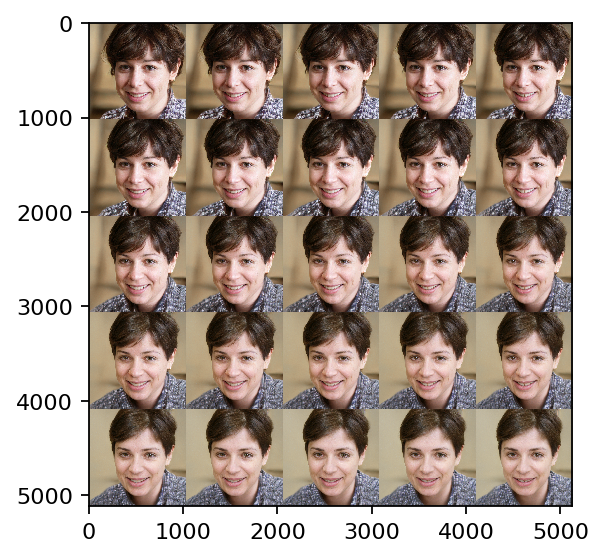

In [2188]:
plt.imshow(gallery)

In [997]:
# Load FaceNet model
model_file = '../cs230/model/facenet_keras.h5'
FRmodel = load_model(model_file)

# Summarize input and output shape
print(FRmodel.inputs)
print(FRmodel.outputs)

[<tf.Tensor 'input_1_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Merge:0' shape=(?, 128) dtype=float32>]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [1554]:
cascade_path = '../cs230/haarcascade_frontalface_default.xml'
image_size = 160

def prewhiten(x):
    
    axis = (1, 2, 3)
    size = x[0].size

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

cascade = cv2.CascadeClassifier(cascade_path)

def align_image(img):
    margin = 10
    faces = cascade.detectMultiScale(img,
                                     scaleFactor=1.1,
                                     minNeighbors=3)
    (x, y, w, h) = faces[0]
    cropped = img[y-margin//2:y+h+margin//2,
                  x-margin//2:x+w+margin//2, :]
    aligned = cv2.resize(cropped, (image_size, image_size))
    return aligned
    
    
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = cv2.resize(cropped, (image_size, image_size))#, mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

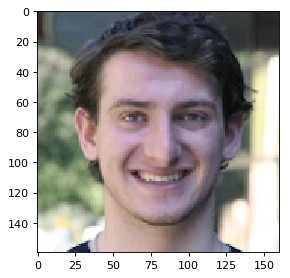

In [605]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# load guiding image
ethan = load_img('../cs230/ethan.jpg', target_size=(160,160,3))
ethan = img_to_array(ethan)
ethan_emb = FRmodel.predict(prewhiten(ethan_color))
mpl.rcParams['figure.dpi']= 80
plt.imshow(ethan/255)

In [1785]:
# Given a set of latent vectors, returns the one with the
# closest FaceNet embedding to the guiding embedding
#
# Returns: (best_latent, best_index, images, loss)
#    best_latent: np array of shape (1, 512)
#    best_index: index of best image
#    images: np array of all images
#    loss: np array of facenet (l2) losses
def get_best_latent(latents, guide_emb):
    images = gen_images(latents)
    resized = np.asarray([cv2.resize(image, (160, 160), interpolation=cv2.INTER_CUBIC) for image in images])
    embeddings = FRmodel.predict(prewhiten(resized))

    loss = np.linalg.norm(embeddings - guide_emb, axis=1)

    best = np.argmin(loss)
    best_latent = latents[best:best+1]
    
    return best_latent, best, images, loss

# copy the latent vector many times and add small noise
# input dim: (1, 512)
def clone_latent_with_noise(latent, std_dev, count):
    next_latent = np.repeat(best_latent, count, axis=0)
    noise = np.random.normal(0, std_dev, next_latent.shape)
    next_latent = next_latent + noise
    return next_latent

In [1787]:
# each iteration looks for 25 images for memory reasons
def search_latent_space(seed_latent, guide_emb, std_dev=1, iterations_per_step=20):
    overall_best = None
    overall_best_img = None
    overall_best_loss = 1000
    
    step_count = 25
    
    all_found_latents = list()
    all_found_losses = list()

    for i in range(iterations_per_step):
#         latents = np.random.normal(0, 1, (25, Gs.input_shape[1]))
        latents = clone_latent_with_noise(seed_latent, std_dev, step_count)
        best, best_index, images, losses = get_best_latent(latents, guide_emb)

        all_found_latents.append(overall_best)
        all_found_losses.append(losses[best_index])
        
        if losses[best_index] < overall_best_loss:
            overall_best = best
            overall_best_loss = losses[best_index]
            overall_best_img = images[best_index]
            
            print('found best so far with loss', overall_best_loss)
    
    return overall_best, overall_best_img, overall_best_loss, all_found_latents, all_found_losses

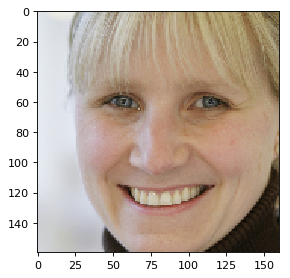

In [2167]:
emb, img = get_embedding_from_img('fool/fool15.png')
mpl.rcParams['figure.dpi']= 80
plt.imshow(img[0])

emb_loss, sorted_args = get_closest_embedding_args(emb)
best_latent = all_latents[sorted_args[0]:sorted_args[0]+1]

In [2168]:
next_losses3 = list()
next_imgs3 = list()
next_vecs3 = list()
next_all_latents3 = list()
next_all_losses3 = list()
for k in range(5):
    
    found_losses = list()
    found_imgs = list()
    found_vecs = list()
    found_all_latents = list()
    found_all_losses = list()
    
    std_devs =   [0.5, 0.45, 0.3, 0.3]
    iterations = [100, 100, 100, 100]
        
    best_latent = all_latents[sorted_args[0]:sorted_args[0]+1]
    guide_emb = emb

    for i in range(len(std_devs)):
        best_latent, best_img, best_loss, all_found_latents, all_found_losses = search_latent_space(best_latent, guide_emb, std_dev=std_devs[i], iterations_per_step=iterations[i])
        found_losses.append(best_loss)
        found_imgs.append(best_img)
        found_vecs.append(best_latent)
        
        found_all_latents.append(all_found_latents)
        found_all_losses.append(all_found_losses)

        print('[iteration', i, ']: embeddings loss: ', best_loss)
        
    next_losses3.append(found_losses)
    next_imgs3.append(found_imgs)
    next_vecs3.append(found_vecs)
    next_all_latents3.append(found_all_latents)
    next_all_losses3.append(found_all_losses)

found best so far with loss 10.2017355
found best so far with loss 10.175509
found best so far with loss 9.866301
found best so far with loss 9.289216
found best so far with loss 9.201251
found best so far with loss 9.135565
found best so far with loss 8.968805
found best so far with loss 8.848944
[iteration 0 ]: embeddings loss:  8.848944
found best so far with loss 9.439655
found best so far with loss 9.222184
found best so far with loss 8.579016
found best so far with loss 8.493101
found best so far with loss 8.306173
found best so far with loss 7.7334332
[iteration 1 ]: embeddings loss:  7.7334332
found best so far with loss 7.777882
found best so far with loss 7.7566123
found best so far with loss 7.570253
found best so far with loss 7.483918
found best so far with loss 7.176284
found best so far with loss 7.1592855
found best so far with loss 6.9917345
found best so far with loss 6.86242
found best so far with loss 6.832506
found best so far with loss 6.72116
[iteration 2 ]: embe

KeyboardInterrupt: 

In [2195]:
# Show losses for each iteration
next_losses3

[[8.848944, 7.7334332, 6.72116, 6.1535816],
 [8.2616205, 7.508328, 7.3713408, 6.465659]]

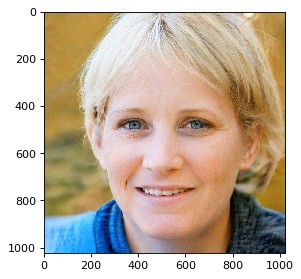

In [2196]:
# Show best generated image
mpl.rcParams['figure.dpi']= 80
plt.imshow(next_imgs3[0][3])

In [ ]:
# returns embedding, img
def get_embedding_from_img(path):
    aligned_img = load_and_align_images([path], margin=10)
    colored_img = np.asarray([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in aligned_img])
    return FRmodel.predict(prewhiten(colored_img)), colored_img
    
def get_closest_embedding_args(to_emb):
    emb_loss = np.linalg.norm(all_embeddings - to_emb, axis=1)
    sorted_args = np.argsort(emb_loss)
    return emb_loss, sorted_args

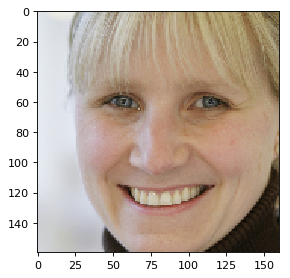

In [2197]:
emb, img = get_embedding_from_img('fool/fool15.png')
# emb, img = get_embedding_from_img('fool/fool21.png')
# emb, img = get_embedding_from_img('../cs230/celeba/img_align_celeba/000170.jpg')
mpl.rcParams['figure.dpi']= 80
plt.imshow(img[0])

In [2198]:
# person = all_embeddings[95525:95525+1]
emb_loss, sorted_args = get_closest_embedding_args(emb)
print('best args: ', sorted_args[:7])
print('losses: ', emb_loss[sorted_args[:7]])

best args:  [132340  51290  78667  60356 148280  89222 218276]
losses:  [9.043178 9.330466 9.500263 9.622124 9.65892  9.691211 9.75702 ]


embedding loss: 9.043178


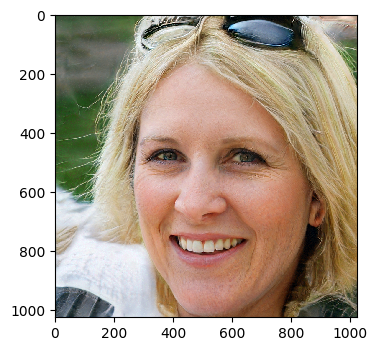

In [2199]:
ind = sorted_args[0]
print('embedding loss:', emb_loss[ind])
images = gen_images(all_latents[ind:ind+1])
mpl.rcParams['figure.dpi']= 100
plt.imshow(images[0])
# al = align_image(images[0])

In [1085]:
# Define starting image to approach
start_img_np = np.array(gan_img)
fz_init = tf.Variable(start_img_np, tf.float32)
fz = tf.expand_dims(fz_init, 0)
fz = tf.cast(fz,tf.float32)

# start_embed = ethan_embs#np.array(pinkman[2])
# fz_init = tf.Variable(start_embed, tf.float32)

# Define the optimization problem
zp = tf.Variable(np.random.normal(size=(1,512)), dtype=tf.float32)
dlatents = Gs.components.mapping.get_output_for(zp, None, is_validation=True)
images = Gs.components.synthesis.get_output_for(dlatents, is_validation=True, randomize_noise=True)
# images = tflib.convert_images_to_uint8(images, nchw_to_nhwc=True)
# fzp = Gs.get_output_for(zp, None, is_validation=True, randomize_noise=False)
# images = fzp#tflib.convert_images_to_uint8(fzp)

# convert to range [0, 255] ints

drange=[-1,1]
images = tf.transpose(images, [0, 2, 3, 1])
scale = 255 / (drange[1] - drange[0])
images = images * scale + (0.5 - drange[0] * scale)


# ------ facenet
# # fzp_small = tf.image.resize(images, size=[160,160], method=tf.image.ResizeMethod.BICUBIC)
# axis = [1, 2, 3]
# # size = fzp_small[0].size
# #     x = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in x])
# mean = tf.math.reduce_mean(fzp_small, axis=axis, keepdims=True)
# std = tf.math.reduce_std(fzp_small, axis=axis, keepdims=True)
# std_adj = tf.math.maximum(std, 1.0)
# #     y = (x - mean) / std_adj

# fzp_norm = tf.math.divide(tf.math.subtract(fzp_small, mean), std_adj)
    
# # fzp_norm = fzp_small - tf.linalg.norm(fzp_small, axis=[1, 2, 3])
# embed = FRmodel(fzp_norm)
# loss = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(fz_init, embed))))
#--------

loss = tf.losses.mean_squared_error(labels=fz, predictions=images)


# Decayed gradient descent
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step,
                                           10000, 0.005)
# opt = tf.train.GradientDescentOptimizer(learning_rate)

opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08)
# Optimize on the variable zp
train = opt.minimize(loss, var_list=zp, global_step=global_step)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

In [1086]:
# global_vars          = tf.global_variables()
# is_not_initialized   = tflib.run([tf.is_variable_initialized(var) for var in global_vars])
# not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

# # print [str(i.name) for i in not_initialized_vars] # only for testing

In [1087]:
tflib.run(fz_init.initializer)
tflib.run(zp.initializer)
tflib.run(global_step.initializer)
tflib.run(tf.variables_initializer(opt.variables()))

In [1088]:
for i in range(500): # Use more iterations (10000)
    # If we know the original latent vector, we can also compute
    # how far the recovered vector is from it
    _, loss_value, zp_val, eta = tflib.run((train, loss, zp, learning_rate))
    #   z_loss = np.sqrt(np.sum(np.square(zp_val - start_zp))/len(zp_val[0]))
    z_norm = np.sqrt(np.sum(np.square(zp_val))/len(zp_val[0]))
    print("%03d) eta=%03f, loss = %f, norm= %f" % (i, eta, loss_value, z_norm))

000) eta=0.001000, loss = 5974.895020, norm= 0.948490
001) eta=0.000999, loss = 5807.722656, norm= 0.948513
002) eta=0.000998, loss = 5619.678223, norm= 0.948524
003) eta=0.000998, loss = 5748.641113, norm= 0.948525
004) eta=0.000997, loss = 5651.132812, norm= 0.948511
005) eta=0.000996, loss = 5590.686035, norm= 0.948501
006) eta=0.000995, loss = 5243.047852, norm= 0.948497
007) eta=0.000995, loss = 5318.972168, norm= 0.948492
008) eta=0.000994, loss = 5173.300293, norm= 0.948488
009) eta=0.000993, loss = 5377.271484, norm= 0.948485
010) eta=0.000992, loss = 5308.226074, norm= 0.948483
011) eta=0.000992, loss = 5151.554199, norm= 0.948481
012) eta=0.000991, loss = 4909.032715, norm= 0.948481
013) eta=0.000990, loss = 5074.804688, norm= 0.948478
014) eta=0.000989, loss = 5047.531738, norm= 0.948476
015) eta=0.000989, loss = 4988.337402, norm= 0.948474
016) eta=0.000988, loss = 4989.613281, norm= 0.948477
017) eta=0.000987, loss = 4860.270020, norm= 0.948480
018) eta=0.000986, loss = 45

152) eta=0.000891, loss = 2743.983398, norm= 0.948647
153) eta=0.000890, loss = 2842.522461, norm= 0.948647
154) eta=0.000890, loss = 2825.131836, norm= 0.948648
155) eta=0.000889, loss = 2797.039062, norm= 0.948650
156) eta=0.000888, loss = 2656.958740, norm= 0.948651
157) eta=0.000888, loss = 2782.132812, norm= 0.948652
158) eta=0.000887, loss = 2837.042236, norm= 0.948654
159) eta=0.000886, loss = 2681.677002, norm= 0.948655
160) eta=0.000885, loss = 2728.241699, norm= 0.948657
161) eta=0.000885, loss = 2864.739014, norm= 0.948659
162) eta=0.000884, loss = 2811.841797, norm= 0.948663
163) eta=0.000883, loss = 2807.852295, norm= 0.948668
164) eta=0.000883, loss = 2736.848877, norm= 0.948672
165) eta=0.000882, loss = 2839.394775, norm= 0.948678
166) eta=0.000881, loss = 2745.015625, norm= 0.948683
167) eta=0.000881, loss = 2858.754883, norm= 0.948687
168) eta=0.000880, loss = 2748.304688, norm= 0.948691
169) eta=0.000879, loss = 2829.061279, norm= 0.948695
170) eta=0.000879, loss = 28

304) eta=0.000794, loss = 2732.118164, norm= 0.949066
305) eta=0.000793, loss = 2826.210205, norm= 0.949068
306) eta=0.000792, loss = 2622.144531, norm= 0.949071
307) eta=0.000792, loss = 2697.213135, norm= 0.949073
308) eta=0.000791, loss = 2612.126953, norm= 0.949076
309) eta=0.000791, loss = 2632.126221, norm= 0.949079
310) eta=0.000790, loss = 2607.209961, norm= 0.949082
311) eta=0.000789, loss = 2653.733643, norm= 0.949084
312) eta=0.000789, loss = 2648.640625, norm= 0.949087
313) eta=0.000788, loss = 2720.620361, norm= 0.949090
314) eta=0.000788, loss = 2626.099365, norm= 0.949092
315) eta=0.000787, loss = 2763.995117, norm= 0.949094
316) eta=0.000786, loss = 2626.621826, norm= 0.949095
317) eta=0.000786, loss = 2523.437744, norm= 0.949096
318) eta=0.000785, loss = 2618.879639, norm= 0.949097
319) eta=0.000785, loss = 2641.385986, norm= 0.949099
320) eta=0.000784, loss = 2516.025146, norm= 0.949101
321) eta=0.000783, loss = 2825.408203, norm= 0.949103
322) eta=0.000783, loss = 27

456) eta=0.000707, loss = 2589.105469, norm= 0.949391
457) eta=0.000707, loss = 2560.125732, norm= 0.949394
458) eta=0.000706, loss = 2475.574951, norm= 0.949396
459) eta=0.000705, loss = 2593.503174, norm= 0.949398
460) eta=0.000705, loss = 2543.772217, norm= 0.949401
461) eta=0.000704, loss = 2411.729492, norm= 0.949404
462) eta=0.000704, loss = 2477.975098, norm= 0.949407
463) eta=0.000703, loss = 2549.668701, norm= 0.949411
464) eta=0.000703, loss = 2389.807373, norm= 0.949415
465) eta=0.000702, loss = 2470.368896, norm= 0.949419
466) eta=0.000702, loss = 2707.917236, norm= 0.949423
467) eta=0.000701, loss = 2514.697266, norm= 0.949427
468) eta=0.000701, loss = 2479.817139, norm= 0.949431
469) eta=0.000700, loss = 2657.241699, norm= 0.949436
470) eta=0.000700, loss = 2520.083740, norm= 0.949440
471) eta=0.000699, loss = 2424.572754, norm= 0.949443
472) eta=0.000699, loss = 2555.479004, norm= 0.949445
473) eta=0.000698, loss = 2460.347656, norm= 0.949448
474) eta=0.000697, loss = 24

In [1089]:
zp_val = tflib.run(zp)

In [1090]:
np.std(zp_val)

0.9492115

In [1091]:
img = gen_images(zp_val)

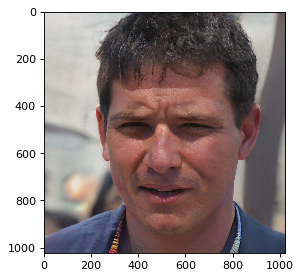

In [1092]:
plt.imshow(img[0])

In [ ]:
# generate 20k * 25 pairs of (latent, embedding)
for i in range(20000):
    latents = gen_latents(30)
    images = gen_images(latents)
    resized = np.asarray([cv2.resize(image, (160, 160), interpolation=cv2.INTER_CUBIC) for image in images])
#     resized = np.asarray([align_image(image) for image in images])
    embeddings = FRmodel.predict(prewhiten(resized))
    all_latents = np.concatenate((all_latents, latents))
    all_embeddings = np.concatenate((all_embeddings, embeddings))
    print('finished iteration', i)

In [1582]:
np.savez_compressed('all_latents_legit.npz', all_latents)
np.savez_compressed('all_embeddings_legit.npz', all_embeddings)

In [1148]:
# Train model to go from embedding to latent
# to anyone reading this: this did not work
from keras import models
from keras import layers
from keras import optimizers

In [1223]:
droprate = 0.2

encoder = models.Sequential()
encoder.add(layers.Dense(128, activation='relu', input_shape=(128,)))
encoder.add(layers.BatchNormalization(momentum=0.8))
encoder.add(layers.Dropout(droprate))
encoder.add(layers.Dense(128, activation='relu'))
encoder.add(layers.BatchNormalization(momentum=0.8))
encoder.add(layers.Dropout(droprate))
encoder.add(layers.Dense(128, activation='relu'))
encoder.add(layers.BatchNormalization(momentum=0.8))
encoder.add(layers.Dropout(droprate))
encoder.add(layers.Dense(256, activation='relu'))
encoder.add(layers.BatchNormalization(momentum=0.8))
encoder.add(layers.Dropout(droprate))
encoder.add(layers.Dense(256, activation='relu'))
encoder.add(layers.BatchNormalization(momentum=0.8))
encoder.add(layers.Dropout(droprate))
encoder.add(layers.Dense(256, activation='relu'))
encoder.add(layers.Dropout(droprate))
encoder.add(layers.Dense(512, activation='tanh'))
encoder.add(layers.Lambda(lambda x: x * 2.5))


# smaller learning rate since embeddings are small
adam = optimizers.Adam(lr=0.001)
encoder.compile(optimizer=adam,
                loss='mean_squared_error',
                metrics=['mse'])

In [ ]:
encoder.fit(x=all_embeddings, y=all_latents, batch_size=128, epochs=200, validation_split=0.1)